In [1]:
import sys
import os

# Add the src folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

import numpy as np
import matplotlib.pyplot as plt

import mesh
import geometry
import material
from stress_strain_analysis import stress_strain_analysis

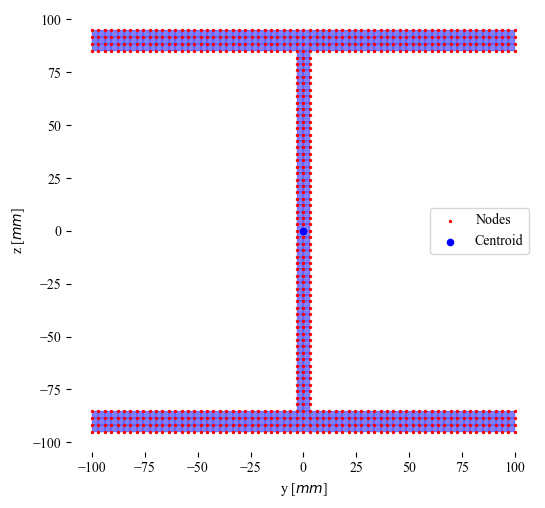

╒════════════════════╤═══════════════╕
│ Mesh Type          │ quadrilateral │
├────────────────────┼───────────────┤
│ Number of elements │ 508           │
├────────────────────┼───────────────┤
│ Number of nodes    │ 701           │
├────────────────────┼───────────────┤
│ Cross Section Area │ 5105.00       │
╘════════════════════╧═══════════════╛
╒═══════════════════╤═════════════╤═════════════╕
│                   │           y │           z │
╞═══════════════════╪═════════════╪═════════════╡
│ Centroid          │       -0.00 │        0.00 │
├───────────────────┼─────────────┼─────────────┤
│ Moment of inertia │ 35094541.67 │ 13337223.85 │
╘═══════════════════╧═════════════╧═════════════╛


In [2]:
H    = geometry.H_beam(web_width     =   6.5,
                       web_height    = 170.0,
                       flange_width  = 200.0,
                       flange_height =  10.0)
Mesh = mesh.Mesh(H, "quadrilateral", 3)

Mesh.plot()
Mesh.print()

In [3]:
Analysis = stress_strain_analysis(Mesh)

Analysis.set_strain_and_curvature(0.00, 0.00002, 0.0)

Analysis.calculate_strains()
Analysis.calculate_stresses()

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.tri as tri
from matplotlib import cm, colors

def plot_stress_strain(self):

	# Normalize strains for color mapping
	max_strain = max(abs(min(self.strains*100)), abs(max(self.strains*100)))
	norm = colors.TwoSlopeNorm(vmin=-max_strain, vcenter=0, vmax=max_strain)
	cmap = plt.colormaps.get_cmap('coolwarm')

	fig, (strains, stresses) = plt.subplots(1,2, figsize=(12, 6))
	
	for i, elem in enumerate(self.mesh.elements):
		x = elem.coords[:, 0]
		y = elem.coords[:, 1]
		poly = patches.Polygon(np.column_stack([x, y]),
								edgecolor='black',
								facecolor=cmap(norm(self.strains[i]*100)),
								lw=0.3)
		strains.add_patch(poly)

	# Plotting nodes to improve visual correctness without marking them
	strains.plot(self.mesh.node_coords[:, 0],
			self.mesh.node_coords[:, 1],
			'o', markersize=0, color='black')

	sm = cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	plt.colorbar(sm, ax=strains, label=r"strain $\varepsilon$ [%]", shrink=0.7)

	strains.set_frame_on(False)
	strains.set_title("strain visualization")
	strains.set_xlim(self.mesh.node_coords[:, 0].min(), self.mesh.node_coords[:, 0].max())
	strains.set_ylim(self.mesh.node_coords[:, 1].min(), self.mesh.node_coords[:, 1].max())
	strains.axes.get_xaxis().set_ticks([])
	strains.axes.get_yaxis().set_ticks([])
	strains.set_aspect('equal')

	# Normalize strains for color mapping
	max_strain = max(abs(min(self.stresses)), abs(max(self.stresses)))
	norm = colors.TwoSlopeNorm(vmin=-max_strain, vcenter=0, vmax=max_strain)
	cmap = plt.colormaps.get_cmap('coolwarm')

	for i, elem in enumerate(self.mesh.elements):
		x = elem.coords[:, 0]
		y = elem.coords[:, 1]
		poly = patches.Polygon(np.column_stack([x, y]),
								edgecolor='black',
								facecolor=cmap(norm(self.stresses[i])),
								lw=0.3)
		stresses.add_patch(poly)

	# Plotting nodes to improve visual correctness without marking them
	stresses.plot(self.mesh.node_coords[:, 0],
			self.mesh.node_coords[:, 1],
			'o', markersize=0, color='black')

	sm = cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	plt.colorbar(sm, ax=stresses, label=r"stress $\sigma$ [MPa]", shrink=0.7)

	stresses.set_frame_on(False)
	stresses.set_title("stress visualization")
	stresses.set_xlim(self.mesh.node_coords[:, 0].min(), self.mesh.node_coords[:, 0].max())
	stresses.set_ylim(self.mesh.node_coords[:, 1].min(), self.mesh.node_coords[:, 1].max())
	stresses.axes.get_xaxis().set_ticks([])
	stresses.axes.get_yaxis().set_ticks([])
	stresses.set_aspect('equal')

	plt.show()


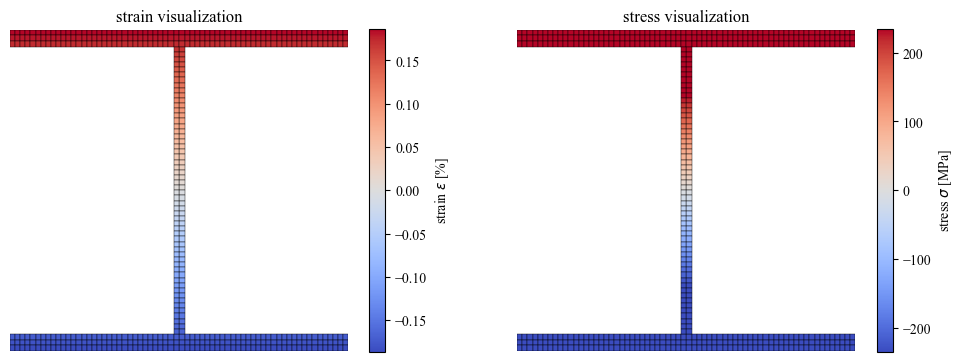

In [5]:
plot_stress_strain(Analysis)

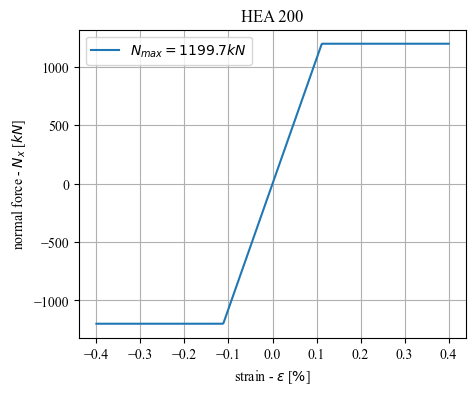

In [6]:
strains = np.linspace(-0.004, 0.004, 500)

Nx = []

for strain in strains:
    Analysis.set_strain_and_curvature(strain, 0, 0)
    Analysis.calculate_strains()
    Analysis.calculate_stresses()
    Nx.append(Analysis.get_section_forces()[0])


plt.figure(figsize=(5, 4))
plt.plot(strains * 100, Nx, label=r"$N_{{max}} = {:.1f} kN$".format(max(Nx)))
plt.xlabel(r'strain - $\varepsilon$ [$\%$]')
plt.ylabel(r'normal force - $N_x$ [$kN$]')
plt.title("HEA 200")
plt.grid()
plt.legend()
plt.savefig('HEA_200_N.png', dpi=300, bbox_inches='tight')
plt.show()

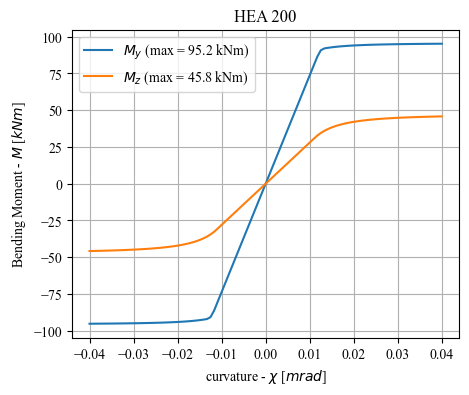

In [22]:
curvs = np.linspace(-0.00004, 0.00004, 100)

My = []
Mz = []

for curv in curvs:
    Analysis.set_strain_and_curvature(0, curv, 0)
    Analysis.calculate_strains()
    Analysis.calculate_stresses()
    My.append(Analysis.get_section_forces()[1])
    Analysis.set_strain_and_curvature(0, 0, curv)
    Analysis.calculate_strains()
    Analysis.calculate_stresses()
    Mz.append(Analysis.get_section_forces()[2])


plt.figure(figsize=(5, 4))
plt.plot(curvs * 1000, My, label=f'$M_y$ (max = {max(My):.3} kNm)')
plt.plot(curvs * 1000, Mz, label=f'$M_z$ (max = {max(Mz):.3} kNm)')
plt.xlabel(r'curvature - $\chi$ [$mrad$]')
plt.ylabel(r'Bending Moment - $M$ [$kNm$]')
plt.title("HEA 200")
plt.grid()
plt.legend()
plt.savefig('HEA_200_M.png', dpi=300, bbox_inches='tight')
plt.show()

In [165]:
from matplotlib import cm, colors

def plot_analysis_my(curv):

	Analysis.set_strain_and_curvature(0.00, curv, 0.0)
	Analysis.calculate_strains()
	Analysis.calculate_stresses()

	# Normalize strains for color mapping
	strains_percent = [x * 100 for x in Analysis.strains]

	max_strain = max(abs(min(strains_percent)), abs(max(strains_percent)))
	norm = colors.TwoSlopeNorm(vmin=-0.3, vcenter=0, vmax=0.3)
	cmap = plt.colormaps.get_cmap('coolwarm')

	fig, (dia, strains, stresses) = plt.subplots(1,3, gridspec_kw={'width_ratios': [3, 3, 3]}, figsize=(17, 4), dpi=200)
	
	for i, elem in enumerate(Analysis.mesh.elements):
		x = elem.coords[:, 0]
		y = elem.coords[:, 1]
		poly = patches.Polygon(np.column_stack([x, y]),
								edgecolor='black',
								facecolor=cmap(norm(Analysis.strains[i]*100)),
								lw=0.3)
		strains.add_patch(poly)

	# Plotting nodes to improve visual correctness without marking them
	strains.plot(Analysis.mesh.node_coords[:, 0],
			Analysis.mesh.node_coords[:, 1],
			'o', markersize=0, color='black')

	sm = cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	plt.colorbar(sm, ax=strains, label=r"strain $\varepsilon$ [%]", shrink=0.7)

	strains.set_frame_on(False)
	strains.set_title("strain visualization")
	strains.set_xlim(Analysis.mesh.node_coords[:, 0].min(), Analysis.mesh.node_coords[:, 0].max())
	strains.set_ylim(Analysis.mesh.node_coords[:, 1].min(), Analysis.mesh.node_coords[:, 1].max())
	strains.axes.get_xaxis().set_ticks([])
	strains.axes.get_yaxis().set_ticks([])
	strains.set_aspect('equal')

	# Normalize strains for color mapping
	max_strain = max(abs(min(Analysis.stresses)), abs(max(Analysis.stresses)))
	norm = colors.TwoSlopeNorm(vmin=-235, vcenter=0, vmax=235)
	cmap = plt.colormaps.get_cmap('coolwarm')

	for i, elem in enumerate(Analysis.mesh.elements):
		x = elem.coords[:, 0]
		y = elem.coords[:, 1]
		if abs(Analysis.stresses[i]) == 235:
			poly = patches.Polygon(np.column_stack([x, y]),
									edgecolor='black',
									facecolor=cmap(norm(Analysis.stresses[i])),
									lw=0.4)
		else:
			poly = patches.Polygon(np.column_stack([x, y]),
									edgecolor='black',
									facecolor=cmap(norm(Analysis.stresses[i])),
									lw=0)
		stresses.add_patch(poly)

	# Plotting nodes to improve visual correctness without marking them
	stresses.plot(Analysis.mesh.node_coords[:, 0],
			Analysis.mesh.node_coords[:, 1],
			'o', markersize=0, color='black')

	sm = cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	plt.colorbar(sm, ax=stresses, label=r"stress $\sigma$ [MPa]", shrink=0.7)

	stresses.set_frame_on(False)
	stresses.set_title("stress visualization")
	stresses.set_xlim(Analysis.mesh.node_coords[:, 0].min(), Analysis.mesh.node_coords[:, 0].max())
	stresses.set_ylim(Analysis.mesh.node_coords[:, 1].min(), Analysis.mesh.node_coords[:, 1].max())
	stresses.axes.get_xaxis().set_ticks([])
	stresses.axes.get_yaxis().set_ticks([])
	stresses.set_aspect('equal')

	curvs = np.linspace(-0.00004, 0.00004, 100)
	My = []
	for c in curvs:
		Analysis.set_strain_and_curvature(0, c, 0)
		Analysis.calculate_strains()
		Analysis.calculate_stresses()
		My.append(Analysis.get_section_forces()[1])

	dia.plot(curvs * 1000, My, label=f'$M_y$ (max = {max(My):.3} kNm)')
	dia.set_xlabel(r'curvature - $\chi$ [$mrad$]')
	dia.set_ylabel(r'Bending Moment - $M_y$ [$kNm$]')
	dia.grid()

	Analysis.set_strain_and_curvature(0, curv, 0)
	Analysis.calculate_strains()
	Analysis.calculate_stresses()
	My = Analysis.get_section_forces()[1]

	dia.scatter(curv * 1000, My, color='red', zorder=5)

	plt.tight_layout()


In [167]:
import os
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np

curvs = np.linspace(0.00000001, 0.00004, 100)

# Create a folder to store frames
os.makedirs("frames", exist_ok=True)

for i, curv in enumerate(curvs):
    plot_analysis_my(curv)
    plt.savefig(f"frames/frame_{i:03d}.png")
    plt.close()

In [174]:
# Create GIF
from PIL import Image

images = [Image.open(f"frames/frame_{i:03d}.png") for i in range(len(curvs))]
images[0].save("HEA_200_My.gif", save_all=True, append_images=images[1:], duration=150, loop=0)

In [ ]:
from matplotlib import cm, colors

def plot_analysis_mz(curv):

	Analysis.set_strain_and_curvature(0.00, 0, curv)
	Analysis.calculate_strains()
	Analysis.calculate_stresses()

	# Normalize strains for color mapping
	strains_percent = [x * 100 for x in Analysis.strains]

	max_strain = max(abs(min(strains_percent)), abs(max(strains_percent)))
	norm = colors.TwoSlopeNorm(vmin=-0.3, vcenter=0, vmax=0.3)
	cmap = plt.colormaps.get_cmap('coolwarm')

	fig, (dia, strains, stresses) = plt.subplots(1,3, gridspec_kw={'width_ratios': [3, 3, 3]}, figsize=(17, 4), dpi=200)
	
	for i, elem in enumerate(Analysis.mesh.elements):
		x = elem.coords[:, 0]
		y = elem.coords[:, 1]
		poly = patches.Polygon(np.column_stack([x, y]),
								edgecolor='black',
								facecolor=cmap(norm(Analysis.strains[i]*100)),
								lw=0.3)
		strains.add_patch(poly)

	# Plotting nodes to improve visual correctness without marking them
	strains.plot(Analysis.mesh.node_coords[:, 0],
			Analysis.mesh.node_coords[:, 1],
			'o', markersize=0, color='black')

	sm = cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	plt.colorbar(sm, ax=strains, label=r"strain $\varepsilon$ [%]", shrink=0.7)

	strains.set_frame_on(False)
	strains.set_title("strain visualization")
	strains.set_xlim(Analysis.mesh.node_coords[:, 0].min(), Analysis.mesh.node_coords[:, 0].max())
	strains.set_ylim(Analysis.mesh.node_coords[:, 1].min(), Analysis.mesh.node_coords[:, 1].max())
	strains.axes.get_xaxis().set_ticks([])
	strains.axes.get_yaxis().set_ticks([])
	strains.set_aspect('equal')

	# Normalize strains for color mapping
	max_strain = max(abs(min(Analysis.stresses)), abs(max(Analysis.stresses)))
	norm = colors.TwoSlopeNorm(vmin=-235, vcenter=0, vmax=235)
	cmap = plt.colormaps.get_cmap('coolwarm')

	for i, elem in enumerate(Analysis.mesh.elements):
		x = elem.coords[:, 0]
		y = elem.coords[:, 1]
		if abs(Analysis.stresses[i]) == 235:
			poly = patches.Polygon(np.column_stack([x, y]),
									edgecolor='black',
									facecolor=cmap(norm(Analysis.stresses[i])),
									lw=0.4)
		else:
			poly = patches.Polygon(np.column_stack([x, y]),
									edgecolor='black',
									facecolor=cmap(norm(Analysis.stresses[i])),
									lw=0)
		stresses.add_patch(poly)

	# Plotting nodes to improve visual correctness without marking them
	stresses.plot(Analysis.mesh.node_coords[:, 0],
			Analysis.mesh.node_coords[:, 1],
			'o', markersize=0, color='black')

	sm = cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	plt.colorbar(sm, ax=stresses, label=r"stress $\sigma$ [MPa]", shrink=0.7)

	stresses.set_frame_on(False)
	stresses.set_title("stress visualization")
	stresses.set_xlim(Analysis.mesh.node_coords[:, 0].min(), Analysis.mesh.node_coords[:, 0].max())
	stresses.set_ylim(Analysis.mesh.node_coords[:, 1].min(), Analysis.mesh.node_coords[:, 1].max())
	stresses.axes.get_xaxis().set_ticks([])
	stresses.axes.get_yaxis().set_ticks([])
	stresses.set_aspect('equal')

	curvs = np.linspace(-0.00004, 0.00004, 100)
	Mz = []
	for c in curvs:
		Analysis.set_strain_and_curvature(0, 0, c)
		Analysis.calculate_strains()
		Analysis.calculate_stresses()
		Mz.append(Analysis.get_section_forces()[2])

	dia.plot(curvs * 1000, Mz, label=f'$M_z$ (max = {max(Mz):.3} kNm)')
	dia.set_xlabel(r'curvature - $\chi$ [$mrad$]')
	dia.set_ylabel(r'Bending Moment - $M_z$ [$kNm$]')
	dia.grid()

	Analysis.set_strain_and_curvature(0, 0, curv)
	Analysis.calculate_strains()
	Analysis.calculate_stresses()
	Mz = Analysis.get_section_forces()[2]

	dia.scatter(curv * 1000, Mz, color='red', zorder=5)

	plt.tight_layout()


KeyboardInterrupt: 

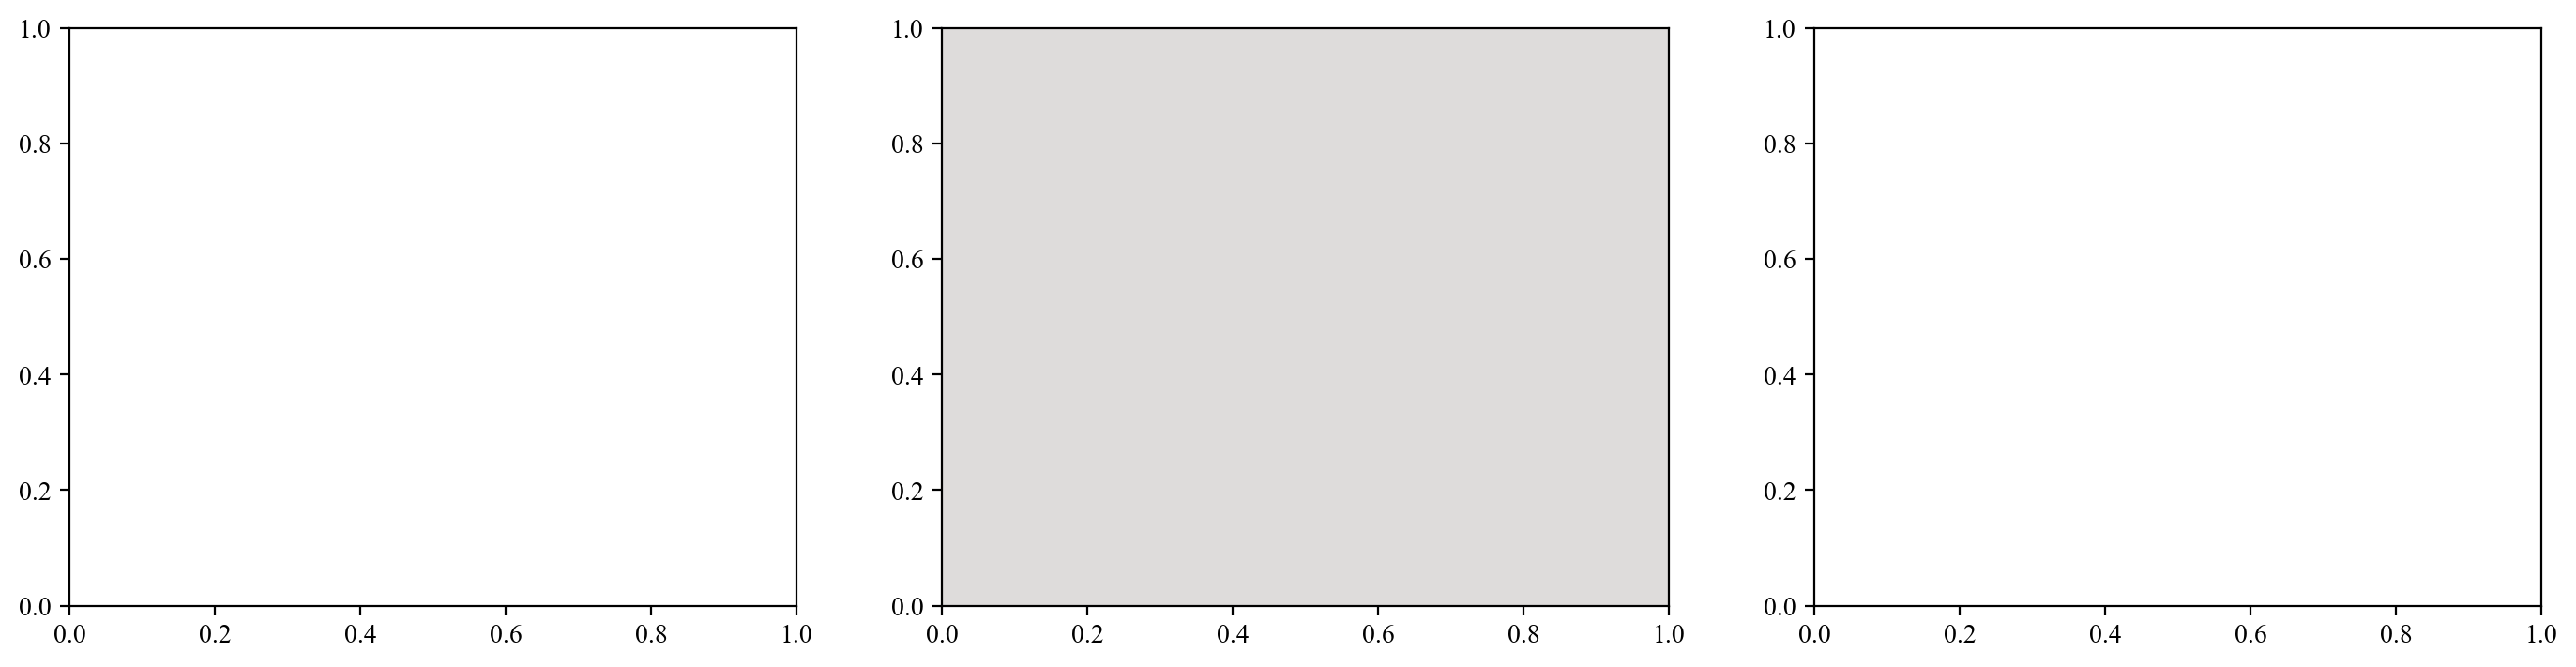

In [184]:
import os
from matplotlib import pyplot as plt
from matplotlib import animation
import numpy as np

curvs = np.linspace(0.00000001, 0.00004, 100)

# Create a folder to store frames
os.makedirs("frames", exist_ok=True)

for i, curv in enumerate(curvs):
    plot_analysis_mz(curv)
    plt.savefig(f"frames/frame_mz_{i:03d}.png")
    plt.close()

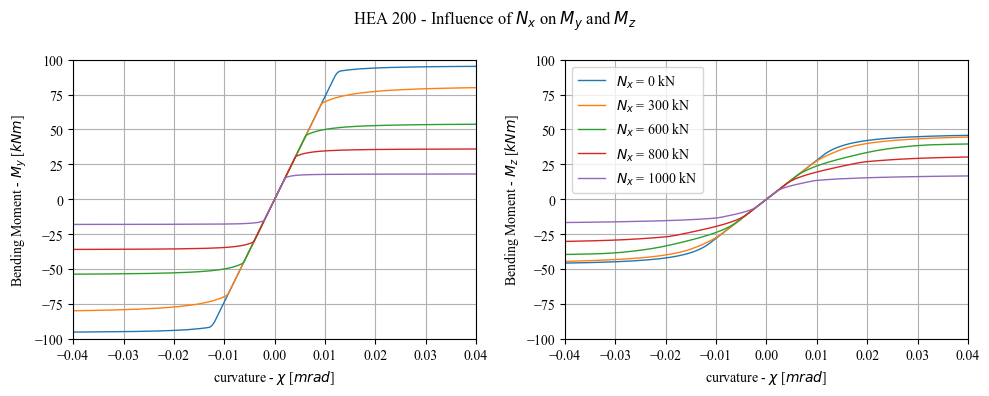

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

My = np.linspace(-100, 100, 1001)
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

# Function to calculate equilibrium for given N and M
def system_of_equations(V, N_target, My_target, Mz_target):
	Analysis.set_strain_and_curvature(V[0], V[1], V[2])
	Analysis.calculate_strains()
	Analysis.calculate_stresses()
	Nx, My, Mz = Analysis.get_section_forces()
	return [Nx - N_target, My - My_target, Mz - Mz_target]


# Plotting the results
fig, (my, mz) = plt.subplots(1,2, figsize=(10, 4))
for j, target_N in enumerate([0, 300, 600, 800, 1000]):
	xsi = []
	M_res = []
	for i, M in enumerate(My):
		initial_guess = [0.0, 0.0, 0.0]
		result = fsolve(system_of_equations, initial_guess, args=(target_N, M, 0), full_output=1)
		if result[2] == 1:
			xsi.append(result[0][1])
			M_res.append(M)
	my.plot([x * 1000 for x in xsi], M_res,linestyle='-',  color=colors[j], lw=1)

Mz = np.linspace(-100, 100, 1001)

for j, target_N in enumerate([0, 300, 600, 800, 1000]):
	xsi = []
	M_res = []
	for i, M in enumerate(Mz):
		initial_guess = [0.0, 0.0, 0.0]
		result = fsolve(system_of_equations, initial_guess, args=(target_N, 0, M), full_output=1)
		if result[2] == 1:
			xsi.append(result[0][2])
			M_res.append(M)
	mz.plot([x * 1000 for x in xsi], M_res,linestyle='-', label=f'$N_x$ = {target_N} kN', color=colors[j], lw=1)

# Plotting the results
plt.suptitle('HEA 200 - Influence of $N_x$ on $M_y$ and $M_z$')
mz.legend()
my.grid()
mz.grid()
my.set_xlim(-0.04, 0.04)
mz.set_xlim(-0.04, 0.04)
my.set_ylim(-100, 100)
mz.set_ylim(-100, 100)
my.set_xlabel(r'curvature - $\chi$ [$mrad$]')
mz.set_xlabel(r'curvature - $\chi$ [$mrad$]')
my.set_ylabel(r'Bending Moment - $M_y$ [$kNm$]')
mz.set_ylabel(r'Bending Moment - $M_z$ [$kNm$]')
plt.tight_layout()
plt.savefig('HEA_200_N_on_My_Mz.png', dpi=300, bbox_inches='tight')
plt.show()

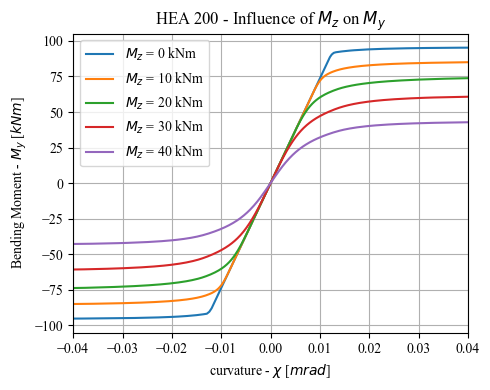

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

My = np.linspace(-100, 100, 1001)

# Function to calculate equilibrium for given N and M
def system_of_equations(V, N_target, My_target, Mz_target):
	Analysis.set_strain_and_curvature(V[0], V[1], V[2])
	Analysis.calculate_strains()
	Analysis.calculate_stresses()
	Nx, My, Mz = Analysis.get_section_forces()
	return [Nx - N_target, My - My_target, Mz - Mz_target]


# Plotting the results
plt.figure(figsize=(5, 4))
for target_Mz in [0, 10, 20, 30, 40]:
	xsi = []
	M_res = []
	for i, M in enumerate(My):
		target_My = M
		initial_guess = [0.0, 0.0, 0.0]  # Initial guess for eps and xsi
		# Solve with fsolve
		result = fsolve(system_of_equations, initial_guess, args=(0, target_My, target_Mz), full_output=1)
		# Check if the solution converged
		if result[2] == 1:
			xsi.append(result[0][1])  # Append the xsi value
			M_res.append(M)
	plt.plot([x * 1000 for x in xsi], M_res,linestyle='-', label=f'$M_z$ = {target_Mz} kNm')

# Plotting the results
plt.title('HEA 200 - Influence of $M_z$ on $M_y$')
plt.legend()
plt.grid()
plt.xlim(-0.04, 0.04)
plt.xlabel(r'curvature - $\chi$ [$mrad$]')
plt.ylabel(r'Bending Moment - $M_y$ [$kNm$]')
plt.tight_layout()
plt.savefig('HEA_200_Mz_on_My.png', dpi=300, bbox_inches='tight')
plt.show()

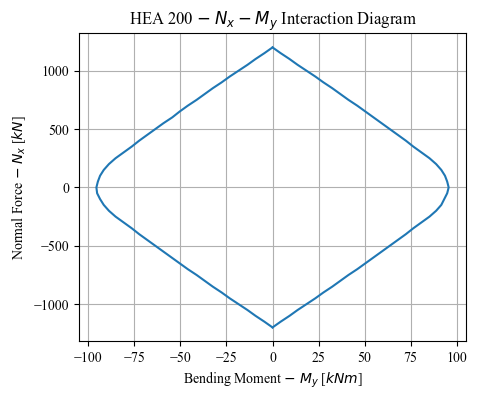

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

N = np.linspace(-1150, 1150, 47)
My = np.linspace(-100, 100, 501)
M_min = [0]
M_max = [0]
Mz = 0

# Find N_min and N_max
N_large = np.linspace(0, 2000, 2001)
N_small = np.linspace(0,-2000, 2001)
N_min = 0
N_max = 0

for i, N_target in enumerate(N_large):
	initial_guess = [0.0, 0.0, 0.0]  # Initial guess for eps and xsi
	# Solve with fsolve
	result = fsolve(system_of_equations, initial_guess, args=(N_target, 0, Mz), full_output=1)
	# Check if the solution converged
	if result[2] == 1:
		N_max = N_target

for i, N_target in enumerate(N_small):
	initial_guess = [0.0, 0.0, 0.0]  # Initial guess for eps and xsi
	# Solve with fsolve
	result = fsolve(system_of_equations, initial_guess, args=(N_target, 0, Mz), full_output=1)
	# Check if the solution converged
	if result[2] == 1:
		N_min = N_target

N_solutions = [N_min]

# Function to calculate equilibrium for given N and M
def system_of_equations(V, N_target, My_target, Mz_target):
	Analysis.set_strain_and_curvature(V[0], V[1], V[2])
	Analysis.calculate_strains()
	Analysis.calculate_stresses()
	Nx, My, Mz = Analysis.get_section_forces()
	return [Nx - N_target, My - My_target, Mz - Mz_target]

for i, N_target in enumerate(N):
	M_res = []
	for i, M in enumerate(My):
		target_M = M
		initial_guess = [0.0, 0.0, 0.0]  # Initial guess for eps and xsi
		# Solve with fsolve
		result = fsolve(system_of_equations, initial_guess, args=(N_target, target_M, Mz), full_output=1)
		# Check if the solution converged
		if result[2] == 1:
			M_res.append(M)
	if len(M_res) > 0:
		# Append the minimum and maximum M values for the current N
		# Check if M_res is not empty before appending
		M_min.append(min(M_res))
		M_max.append(max(M_res))
		N_solutions.append(N_target)

M_min.append(0)
M_max.append(0)
N_solutions.append(N_max)

# Plotting the results
plt.figure(figsize=(5, 4))
plt.plot(M_min, N_solutions,linestyle='-', color='C0')
plt.plot(M_max, N_solutions,linestyle='-', color='C0')
plt.grid()
plt.xlabel('Bending Moment $-$ $M_y$ [$kNm$]')
plt.ylabel('Normal Force $-$ $N_x$ [$kN$]')
plt.title('HEA 200 $-$ $N_x-M_y$ Interaction Diagram')
plt.savefig('HEA_200_N_M_interaction.png', dpi=300, bbox_inches='tight')
plt.show()


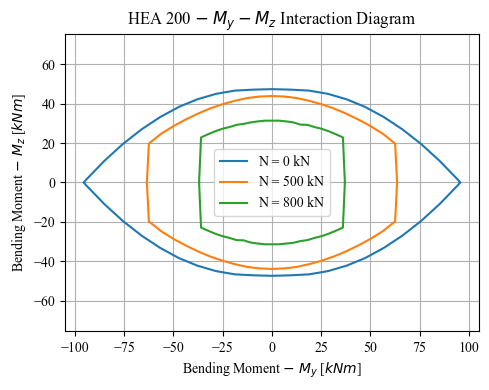

In [79]:
plt.figure(figsize=(5, 4))
c = ['C0', 'C1', 'C2']

for i, N_target in enumerate([0, 500, 800]):
	# --- Parameters ---
	Mz_range = np.linspace(-50, 50, 801)

	# --- Initialize result containers ---
	Mz_neg = [0]
	Mz_pos = [0]

	# Find My_min and My_max
	My = np.linspace(0, 100, 201)

	for My_target in My:
		initial_guess = [0.0, 0.0, 0.0]  # Initial guess for eps and xsi
		# Solve with fsolve
		result = fsolve(system_of_equations, initial_guess, args=(N_target, My_target, 0), full_output=1)
		# Check if the solution converged
		if result[2] == 1:
			My_max = My_target

	My_sol = [-My_max]
	
	My_range = np.linspace(-My_max+1, My_max-1, 21)

	# --- Main sweep over My and Mz grid ---
	for My in My_range:
		Mz_success = []
		for Mz in Mz_range:
			initial_guess = [0.0, 0.0, 0.0]
			result = fsolve(system_of_equations, initial_guess, args=(N_target, My, Mz), full_output=1)
			if result[2] == 1:
				Mz_success.append(Mz)
		if len(Mz_success) > 0:
			My_sol.append(My)
			Mz_neg.append(min(Mz_success))
			Mz_pos.append(max(Mz_success))
	
	My_sol.append(My_max)
	Mz_neg.append(0)
	Mz_pos.append(0)

	plt.plot(My_sol, Mz_neg, color=c[i])
	plt.plot(My_sol, Mz_pos, color=c[i], label=f"N = {N_target} kN")


plt.xlabel("Bending Moment $-$ $M_y$ [$kNm$]")
plt.ylabel("Bending Moment $-$ $M_z$ [$kNm$]")
plt.title("HEA 200 $-$ $M_y-M_z$ Interaction Diagram")
plt.grid()
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.savefig('HEA_200_My_Mz_interaction.png', dpi=300, bbox_inches='tight')
plt.show()

(np.float64(-105.16), np.float64(105.16), np.float64(-47.3), np.float64(47.3))

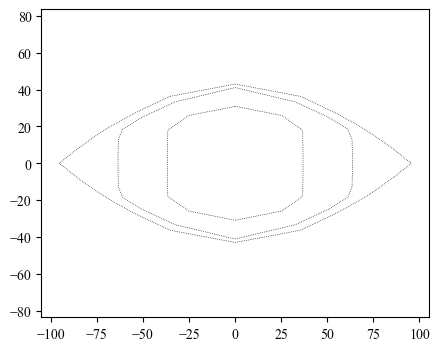

In [73]:
import pandas as pd

# Load data
file1 = 'HEA_200_N_0.csv'
file2 = 'HEA_200_N_500.csv'
file3 = 'HEA_200_N_800.csv'

df1 = pd.read_csv(file1, sep=';')
df2 = pd.read_csv(file2, sep=';')
df3 = pd.read_csv(file3, sep=';')

# Plotting
plt.figure(figsize=(5, 4))

plt.plot(df1['My'], df1['Mz'], linestyle='dotted', lw=0.5, color="k")
plt.plot(df2['My'], df2['Mz'], linestyle='dotted', lw=0.5, color="k")
plt.plot(df3['My'], df3['Mz'], linestyle='dotted', label='Fagus', lw=0.5, color="k")
plt.axis('equal')


In [ ]:
def system_of_equations(V, N_target, My_target, Mz_target):
    Analysis.set_strain_and_curvature(V[0], V[1], V[2])
    Analysis.calculate_strains()
    Analysis.calculate_stresses()
    Nx, My, Mz = Analysis.get_section_forces()
    return [Nx - N_target, My - My_target, Mz - Mz_target]

# --- Check if a solution exists for given R and angle θ ---
def system_has_solution(R, theta):
    N_target = R * np.cos(theta)
    My_target = R * np.sin(theta)
    initial_guess = [0.0, 0.0, 0.0]
    result = fsolve(system_of_equations, initial_guess, args=(N_target, My_target, 0), full_output=1)
    return result[2] == 1  # Convergence success

angles = np.linspace(0, 2 * np.pi, 100)
N_values = []
M_values = []

R_range = np.linspace(0, 1200, 1000)  # Adjust max range as needed

for theta in angles:
    R_found = None
    for R in R_range:
        if system_has_solution(R, theta):
            R_found = R
        else:
            continue
    if R_found is not None:
        N_values.append(R_found * np.cos(theta))
        M_values.append(R_found * np.sin(theta))

plt.figure(figsize=(8, 6))
plt.plot(M_values, N_values, label="Interaction Curve", color="darkred")
plt.xlabel("Bending Moment My")
plt.ylabel("Normal Force N")
plt.title("My–N Interaction Diagram (Adaptive Sweep)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()